<a href="https://colab.research.google.com/github/Series-Parallel/Machine_in_Deep_Learning/blob/main/Multiple_inputs_and_outputs_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

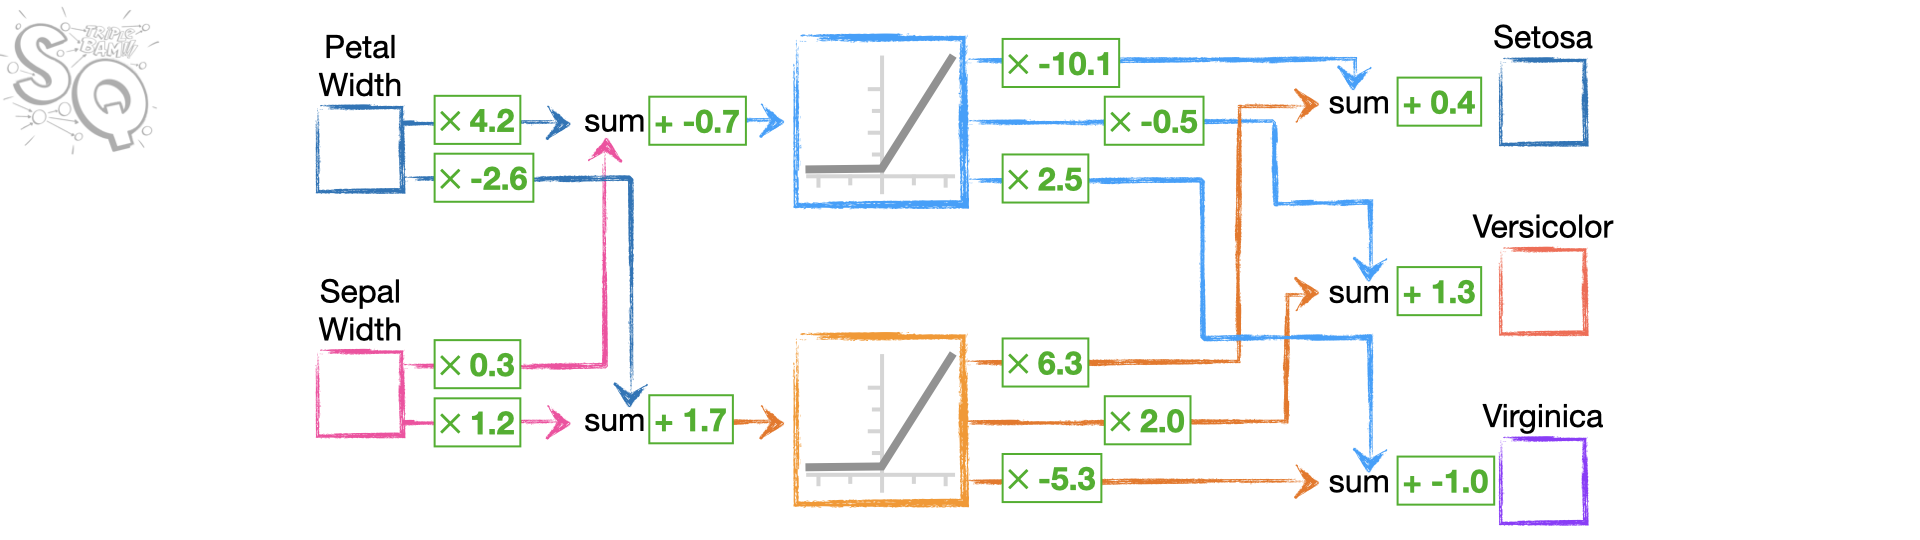

# Import and Format data and then Build a DataLoader From Scratch.

In [1]:
!pip install lightning > /dev/null

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split

In [44]:
url = "https://raw.githubusercontent.com/StatQuest/signa/main/chapter_03/iris.txt"
df = pd.read_table(url, sep=",", header=None)

In [45]:
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [46]:
df.columns = ["sepal_length",
              "sepal_width",
              "petal_length",
              "petal_width",
              "class"]
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [47]:
df["class"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [48]:
for class_name in df['class'].unique(): # for each unique class name...

    ## ...print out the number of rows associated with it
    print(class_name, ": ", sum(df['class'] == class_name), sep="")

Iris-setosa: 50
Iris-versicolor: 50
Iris-virginica: 50


In [49]:
df[['petal_width', 'sepal_width']].head()

,petal_width,sepal_width
0,0.2,3.5
1,0.2,3.0
2,0.2,3.2
3,0.2,3.1
4,0.2,3.6


In [50]:
input_values = df[['petal_width', 'sepal_width']]
input_values.head()

,petal_width,sepal_width
0,0.2,3.5
1,0.2,3.0
2,0.2,3.2
3,0.2,3.1
4,0.2,3.6


In [51]:
label_values = df['class']
label_values.head()

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


In [52]:
classes_as_numbers = label_values.factorize()[0]
classes_as_numbers

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [53]:
input_train, input_test, label_train, label_test = train_test_split(input_values,
                                                                    classes_as_numbers,
                                                                    test_size=0.25,
                                                                    stratify=classes_as_numbers)

In [54]:
input_train.shape

(112, 2)

In [55]:
label_train.shape

(112,)

In [56]:
input_test.shape

(38, 2)

In [57]:
label_test.shape

(38,)

Now, because our neural network will have 3 outputs, one for each species (see the drawing of the neural network above), we need to convert the numbers in label_train into 3 element arrays, where each element in an array corresponds to a specific output in the neural network. Specifically, we'll use [1.0, 0.0, 0.0] to correspond to Setosa, [0.0, 1.0, 0.0] for Versicolor, and [0.0, 0.0, 1.0] for Virginica. The good news is that we can easily do the one-hot encoding. We also tack on type(torch.float32) to ensure the numbers are saved in the correct format for the neural network to process efficiently.

In [58]:
one_hot_label_train = F.one_hot(torch.tensor(label_train)).type(torch.float32)

In [59]:
one_hot_label_train[:10]

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])

Now, let's normalize the input variables so that their values range from 0 to 1. Normalizing data, so that it's all on the same scale, often makes it easier to train machine learning methods. In this case, since we have two datasets, input_train and input_test, we'll start determining the maximum and minimum values in input_train. Then we will use those values to normalize input_train and input_test. Using the maximum and minimum values from input_train to normalize both datasets avoids something called Data Leakage.

In [60]:
max_vals_in_input_train = input_train.max()

In [61]:
max_vals_in_input_train

,0
petal_width,2.5
sepal_width,4.4


In [62]:
min_vals_in_input_train = input_train.min()

In [63]:
min_vals_in_input_train

,0
petal_width,0.1
sepal_width,2.0


In [64]:
input_train = (input_train - min_vals_in_input_train) / (max_vals_in_input_train - min_vals_in_input_train)
input_train.head()

,petal_width,sepal_width
130,0.750000,0.333333
122,0.791667,0.333333
81,0.375000,0.166667
71,0.500000,0.333333
89,0.500000,0.208333


In [65]:
input_test = (input_test - min_vals_in_input_train) / (max_vals_in_input_train - min_vals_in_input_train)
input_test.head()

,petal_width,sepal_width
42,0.041667,0.500000
56,0.625000,0.541667
99,0.500000,0.333333
53,0.500000,0.125000
38,0.041667,0.416667


Now, let's put our training data into a DataLoader, which we can use to train the neural network. DataLoaders are great for large datasets because they make it easy to access the data in batches, make it easy to shuffle the data each epoch, and they make it easy to use a relatively small fraction of the data if we want to do a quick and dirty training for debugging our code.

To put our data training data into a DataLoader, we'll start by converting input_train into tensors with torch.tensor(). We'll then combine 'input_train with one_hot_label_train to create a TensorDataset. Lastly, we'll use the TensorDataset to create the DataLoader.

In [66]:
input_train_tensors = torch.tensor(input_train.values).type(torch.float32)

In [67]:
input_train_tensors[:5]

tensor([[0.7500, 0.3333],
        [0.7917, 0.3333],
        [0.3750, 0.1667],
        [0.5000, 0.3333],
        [0.5000, 0.2083]])

In [68]:
input_test_tensors = torch.tensor(input_test.values).type(torch.float32)

In [69]:
input_test_tensors[:5]

tensor([[0.0417, 0.5000],
        [0.6250, 0.5417],
        [0.5000, 0.3333],
        [0.5000, 0.1250],
        [0.0417, 0.4167]])

In [70]:
train_dataset = TensorDataset(input_train_tensors, one_hot_label_train)
train_dataloader = DataLoader(train_dataset)

# Building a neural network with multiple inputs and outputs with PyTorch and Lightning

In [75]:
class MultipleInsOuts(L.LightningModule):

  def __init__(self):
    super().__init__()

    L.seed_everything(seed=42)

    self.input_to_hidden = nn.Linear(in_features=2, out_features=2, bias=True)
    self.hidden_to_output = nn.Linear(in_features=2, out_features=3, bias=True)
    self.loss = nn.MSELoss(reduction='sum')


  def forward(self, input):
    hidden = self.input_to_hidden(input)
    output_values = self.hidden_to_output(torch.relu(hidden))

    return (output_values)


  def configure_optimizers(self):
     return Adam(self.parameters(), lr=0.001)


  def training_step(self, batch, batch_idx):
    inputs, labels = batch
    outputs = self.forward(inputs)
    loss = self.loss(outputs, labels)

    return loss


In [76]:
model = MultipleInsOuts()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [77]:
for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=2))

input_to_hidden.weight tensor([[ 0.5400,  0.5900],
        [-0.1700,  0.6500]])
input_to_hidden.bias tensor([-0.1500,  0.1400])
hidden_to_output.weight tensor([[-0.3400,  0.4200],
        [ 0.6200, -0.5200],
        [ 0.6100,  0.1300]])
hidden_to_output.bias tensor([0.5200, 0.1000, 0.3400])


# Training our Neural Network

In [78]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders=train_dataloader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name             | Type    | Params | Mode 
-----------------------------------------------------
0 | input_to_hidden  | Linear  | 6      | train
1 | hidden_to_o

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [79]:
predictions = model(input_test_tensors)

In [80]:
predictions[0:4,]

tensor([[0.7585, 0.0282, 0.0331],
        [0.1994, 0.3877, 0.4948],
        [0.2486, 0.3490, 0.3868],
        [0.1941, 0.3776, 0.3712]], grad_fn=<SliceBackward0>)

In [81]:
predicted_labels = torch.argmax(predictions, dim=1) ## dim=0 applies argmax to rows, dim=1 applies argmax to columns
predicted_labels[0:4]

tensor([0, 2, 2, 1])

In [82]:
torch.sum(torch.eq(torch.tensor(label_test), predicted_labels)) / len(predicted_labels)

tensor(0.7368)

We see that our neural network only correctly predicts 74% of the testing data. This isn't very good. So, will training our model for more epochs improve the model's predictions?

One way to answer that question is to just train for longer and see what happens.

The good news is that because we're using Lightning, we can pick up where we left off training without starting over from scratch. This is because training with Lightning creates checkpoint files that keep track of the Weights and Biases as they change. As a result, all we have to do to pick up where we left off is tell the Trainer where the checkpoint files are. This is awesome and will save us a lot of time since we don't have to retrain the first 10 epochs. So, let's add an additional 90 epochs to the training.

To add additional epochs to the training, we first identify where the checkpoint file is with the following command

In [83]:
path_to_checkpoint = trainer.checkpoint_callback.best_model_path

In [84]:
trainer = L.Trainer(max_epochs=100)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [85]:
trainer.fit(model, train_dataloaders=train_dataloader, ckpt_path=path_to_checkpoint)

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=9-step=1120.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=9-step=1120.ckpt
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:366: The dirpath has changed from '/content/lightning_logs/version_2/checkpoints' to '/content/lightning_logs/version_3/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO: 
  | Name             | Type    | Params | Mode 
-----------------------------------------------------
0 | input_to_hidden  | Linear  | 6      | train
1 | hidden_to_output | Linear  | 9      | train
2 | loss             | MSELoss | 0      | train
-----------------------------------------------------
15        Trainable params
0  

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [86]:
predictions = model(input_test_tensors)

In [87]:
predicted_labels = torch.argmax(predictions, dim=1)

In [88]:
torch.sum(torch.eq(torch.tensor(label_test), predicted_labels)) / len(predicted_labels)

tensor(0.9211)

After 100 training epochs, we correctly classified 92% of the testing data. This means adding more training was helpful!

# Make a Prediction with New Data

In [89]:
normalized_values = ([0.2, 3.0] - min_vals_in_input_train) / (max_vals_in_input_train - min_vals_in_input_train)
normalized_values

,0
petal_width,0.041667
sepal_width,0.416667


In [90]:
model(torch.tensor(normalized_values).type(torch.float32))

/tmp/ipython-input-90-3219751161.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model(torch.tensor(normalized_values).type(torch.float32))


tensor([ 0.7956,  0.1990, -0.0419], grad_fn=<ViewBackward0>)

first output has the largest value, meaning that the neural network predicts that the measurements come from Setosa.